# Лабораторная работа 1: Линейная регрессия

## Описание
В данной работе реализуется модель линейной регрессии с различными методами оптимизации,
метриками качества и методами валидации.

**Цель:** Предсказать RiskScore на основе признаков из датасета

## 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)

## 2. Загрузка данных

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

train_df.head()

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,31.347091


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIncomeRatio           104

In [4]:
train_df.describe()

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,RiskScore
count,10487.000000,10487.000000,9986.000000,9986.000000,10487.000000,10487.000000,9986.000000,10487.000000,10487.000000,10487.000000,...,10487.000000,10487.000000,10487.000000,10487.000000,9.986000e+03,9986.000000,10487.000000,10487.000000,10487.000000,1.048700e+04
mean,39.850386,131587.872127,678.082716,29874.218306,53.439878,1.568323,546.458642,0.284397,3.033565,0.979498,...,10838.934141,0.784428,4.949271,17.628302,1.542381e+05,0.200392,0.200112,1075.622426,0.517577,-2.569878e+04
std,11.614132,115791.941909,175.192486,27705.509722,24.493562,1.418684,501.981888,0.159240,1.740186,0.990927,...,9385.924858,0.123039,2.201100,11.337248,4.622229e+05,0.094388,0.096458,1344.053181,0.894637,1.431675e+06
min,18.000000,15000.000000,300.000000,1063.000000,12.000000,0.000000,13.000000,0.003674,0.000000,0.000000,...,1250.000000,0.259301,0.000000,0.000000,1.004000e+03,0.052494,0.046445,30.008506,0.006064,-9.999999e+06
25%,32.000000,20959.500000,550.000000,12658.000000,36.000000,0.000000,233.250000,0.158929,2.000000,0.000000,...,1683.541667,0.708475,3.000000,9.000000,7.252500e+03,0.119908,0.119548,375.872620,0.066734,3.256475e+01
50%,40.000000,89015.000000,722.500000,21828.500000,48.000000,1.000000,398.000000,0.262229,3.000000,1.000000,...,7371.250000,0.803692,5.000000,17.000000,2.742950e+04,0.182023,0.180710,684.878529,0.178193,4.411876e+01
75%,48.000000,257025.000000,850.000000,37158.000000,60.000000,3.000000,685.000000,0.391683,4.000000,2.000000,...,21232.583333,0.879312,6.000000,26.000000,1.241758e+05,0.264709,0.264880,1279.930203,0.637457,6.535690e+01
max,80.000000,748508.000000,850.000000,418997.000000,120.000000,6.000000,10879.000000,0.914635,12.000000,6.000000,...,25000.000000,0.996573,17.000000,57.000000,1.126117e+07,0.722497,0.833647,29634.807816,24.383046,1.000000e+07


## 3. EDA - Разведочный анализ данных (1 балл)

Построение графиков зависимости признаков, распределения целевой переменной и матрицы корреляций

In [5]:
print("Пропущенные значения:")
print(train_df.isnull().sum())

Пропущенные значения:
ApplicationDate                530
Age                            530
AnnualIncome                   530
CreditScore                   1031
LoanAmount                    1031
LoanDuration                   530
MaritalStatus                  530
NumberOfDependents             530
HomeOwnershipStatus            530
MonthlyDebtPayments           1031
CreditCardUtilizationRate      530
NumberOfOpenCreditLines        530
NumberOfCreditInquiries        530
DebtToIncomeRatio              530
BankruptcyHistory             1031
LoanPurpose                   1031
PreviousLoanDefaults           530
PaymentHistory                 530
LengthOfCreditHistory          530
SavingsAccountBalance          530
CheckingAccountBalance        1031
TotalAssets                   1031
TotalLiabilities               530
MonthlyIncome                  530
UtilityBillsPaymentHistory     530
JobTenure                      530
EmploymentStatus               530
EducationLevel                 53

In [6]:
print(train_df.RiskScore.quantile([0.011, 0.012, 0.991, 0.992]))

low_q = train_df.RiskScore.quantile(0.011)
top_q = train_df.RiskScore.quantile(0.992)

train_df = train_df[(train_df.RiskScore > low_q) & (train_df.RiskScore < top_q)]

train_df.dropna(inplace=True)

0.011   -9.999999e+06
0.012    1.904133e+01
0.991    9.706441e+01
0.992    1.000000e+07
Name: RiskScore, dtype: float64


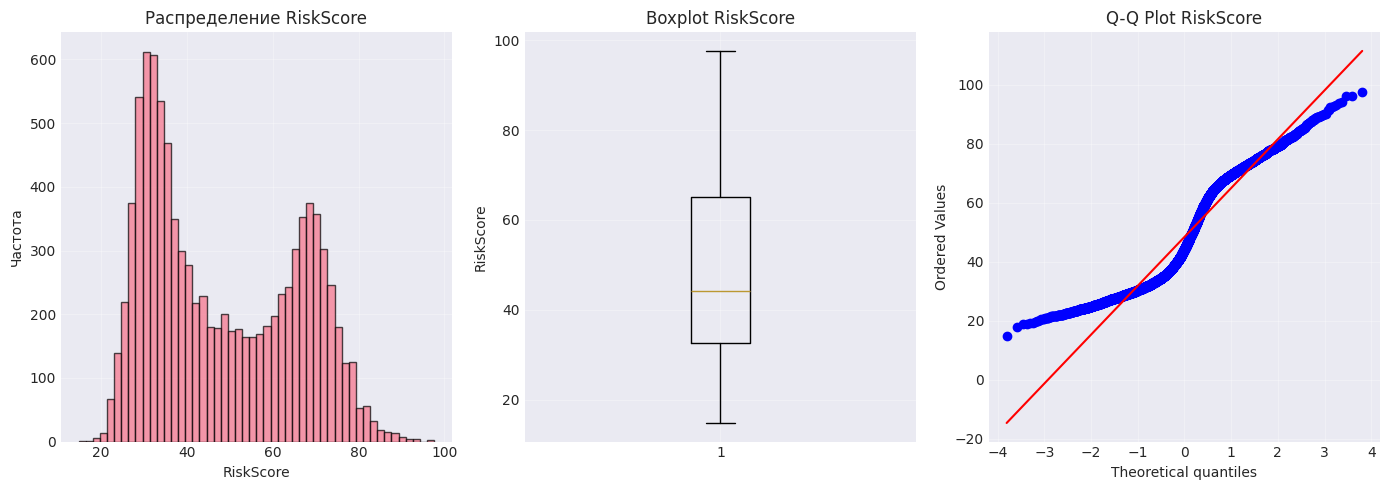

Среднее значение RiskScore: 48.35
Медиана RiskScore: 44.15
Стандартное отклонение: 17.26


In [7]:
# Распределение целевой переменной
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['RiskScore'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.title('Распределение RiskScore')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.boxplot(train_df['RiskScore'])
plt.ylabel('RiskScore')
plt.title('Boxplot RiskScore')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(train_df['RiskScore'], dist="norm", plot=plt)
plt.title('Q-Q Plot RiskScore')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Среднее значение RiskScore: {train_df['RiskScore'].mean():.2f}")
print(f"Медиана RiskScore: {train_df['RiskScore'].median():.2f}")
print(f"Стандартное отклонение: {train_df['RiskScore'].std():.2f}")

In [8]:
# Выбираем числовые признаки (исключаем ID и целевую переменную)
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'ID' in numeric_features:
    numeric_features.remove('ID')
if 'RiskScore' in numeric_features:
    numeric_features.remove('RiskScore')

print(f"Количество числовых признаков: {len(numeric_features)}")
print(f"Признаки: {numeric_features[:10]}...")  # Показываем первые 10

Количество числовых признаков: 28
Признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries']...


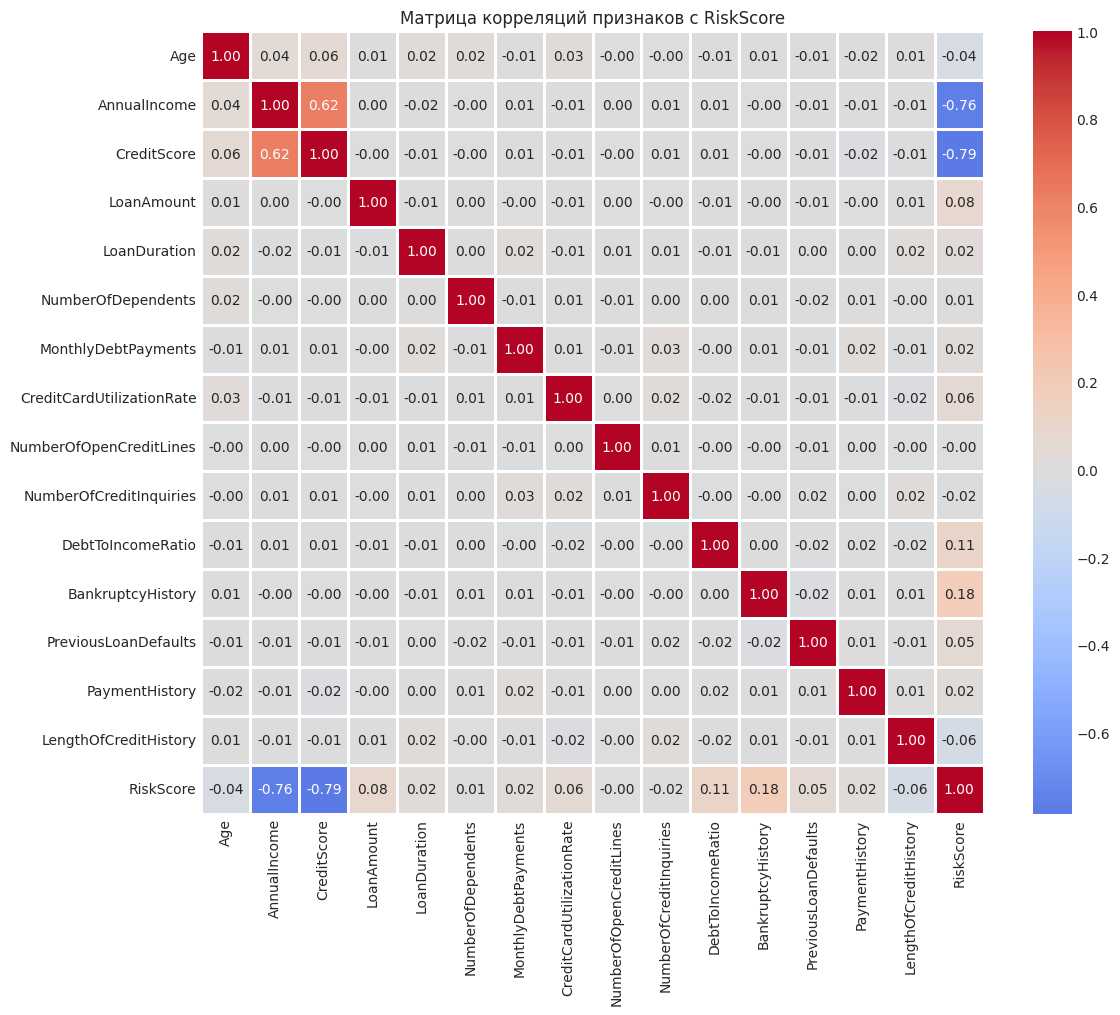


Топ-10 признаков по корреляции с RiskScore:
CreditScore               0.785425
MonthlyIncome             0.770608
BaseInterestRate          0.758712
AnnualIncome              0.758480
InterestRate              0.742940
TotalDebtToIncomeRatio    0.532384
BankruptcyHistory         0.177559
MonthlyLoanPayment        0.151459
TotalAssets               0.145735
NetWorth                  0.144574
Name: RiskScore, dtype: float64


In [9]:
# Матрица корреляций (для первых N признаков + целевая переменная)
n_features_to_plot = min(15, len(numeric_features))
features_for_corr = numeric_features[:n_features_to_plot] + ['RiskScore']

plt.figure(figsize=(12, 10))
correlation_matrix = train_df[features_for_corr].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Матрица корреляций признаков с RiskScore')
plt.tight_layout()
plt.show()

# Топ признаков по корреляции с целевой переменной
correlations = train_df[numeric_features + ['RiskScore']].corr()['RiskScore'].drop('RiskScore')
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
print("\nТоп-10 признаков по корреляции с RiskScore:")
print(top_correlations)

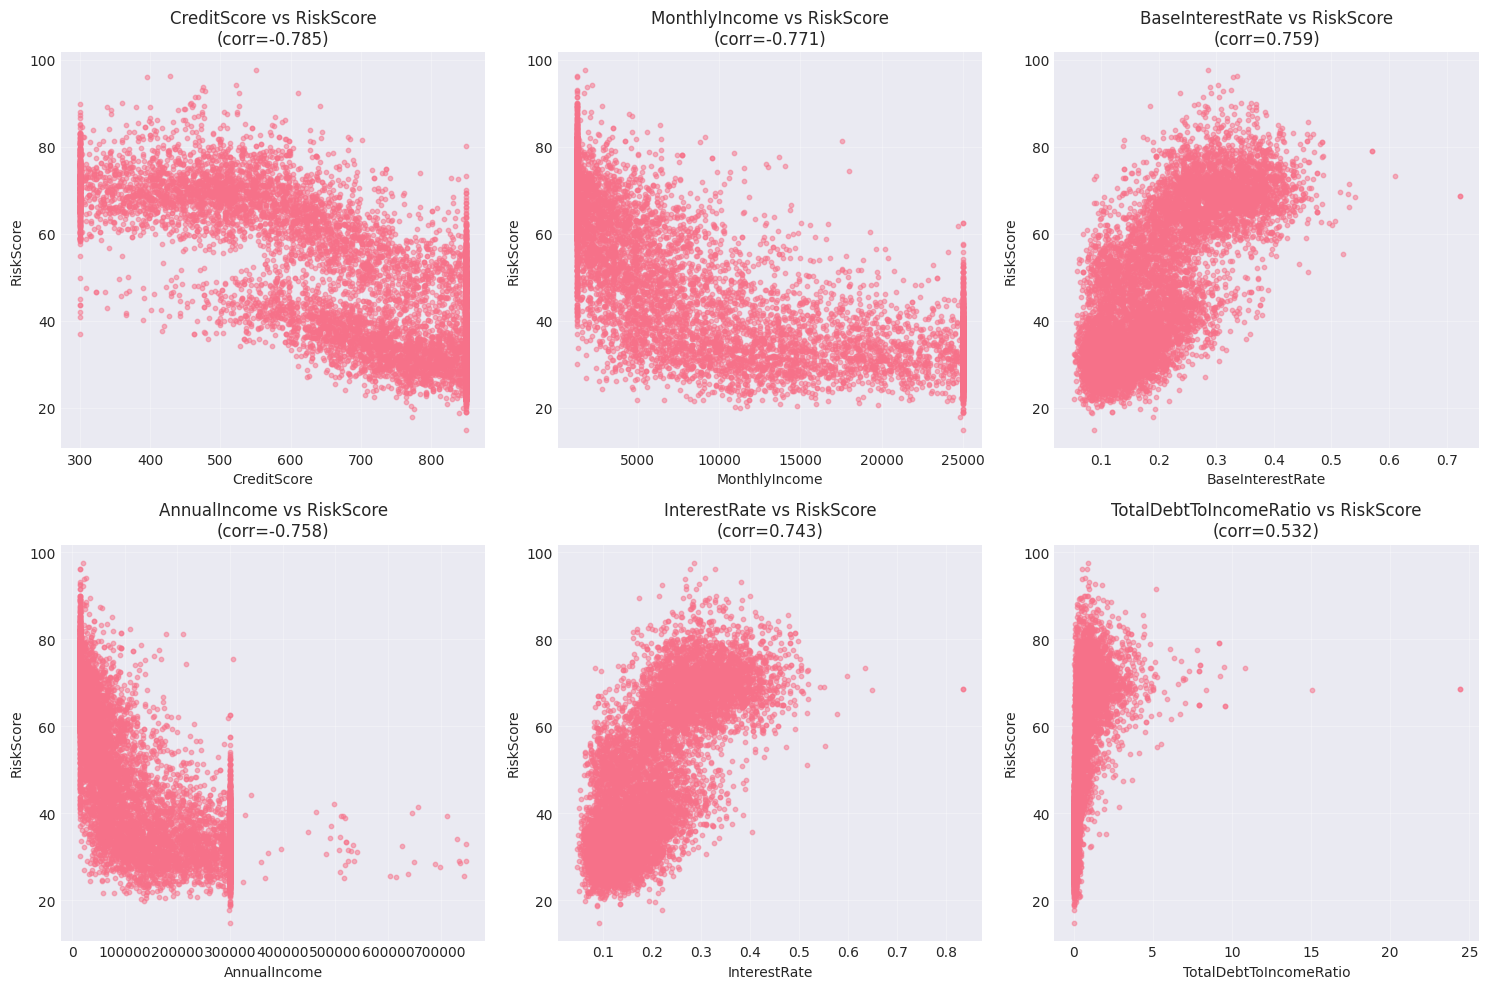

In [10]:
# Scatter plots для топ-6 признаков с наибольшей корреляцией
top_features = correlations.abs().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train_df[feature], train_df['RiskScore'], alpha=0.5, s=10)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('RiskScore')
    axes[idx].set_title(f'{feature} vs RiskScore\n(corr={correlations[feature]:.3f})')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Выводы по EDA:

1. **Целевая переменная (RiskScore)**: Изучили распределение, среднее значение, наличие выбросов
2. **Корреляции**: Определили признаки с наибольшей корреляцией с целевой переменной
3. **Пропущенные значения**: Проверили наличие пропусков в данных
4. **Зависимости**: Визуализировали взаимосвязи между ключевыми признаками и целевой переменной

## 4. Подготовка данных

In [11]:
# Отделяем ID и целевую переменную
X_train = train_df.drop(['RiskScore'], axis=1)
y_train = train_df['RiskScore'].values

# Для тестовой выборки
X_test = test_df.copy()

# Сохраняем ID для submission
if 'ID' in X_train.columns:
    train_ids = X_train['ID'].values
    X_train = X_train.drop(['ID'], axis=1)

if 'ID' in X_test.columns:
    test_ids = X_test['ID'].values
    X_test = X_test.drop(['ID'], axis=1)

# Обработка категориальных признаков (если есть)
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    print(f"Найдены категориальные признаки: {categorical_features}")
    X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
    X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
    
    # Выравниваем колонки
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Конвертируем в numpy arrays
X_train = X_train.values
X_test = X_test.values

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер y_train: {y_train.shape}")

Найдены категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
Размер обучающей выборки: (9787, 9375)
Размер тестовой выборки: (5000, 9375)
Размер y_train: (9787,)


## 5. Нормализация данных (1 балл)

Реализация Z-score и Min-Max нормализации

In [12]:
class CustomNormalizer:
    """
    Класс для нормализации данных с использованием Z-score и Min-Max методов
    """
    
    def __init__(self, method='zscore'):
        """
        Parameters:
        -----------
        method : str, default='zscore'
            Метод нормализации: 'zscore' или 'minmax'
        """
        self.method = method
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None
        self.range_ = None
        
    def fit(self, X):
        """
        Вычисляет параметры нормализации на обучающих данных
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Обучающие данные
        """
        # Конвертируем в numpy array с типом float64
        X = np.asarray(X, dtype=np.float64)
        
        if self.method == 'zscore':
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
            # Избегаем деления на ноль
            self.std_[self.std_ == 0] = 1
        elif self.method == 'minmax':
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
            # Избегаем деления на ноль
            self.range_ = self.max_ - self.min_
            self.range_[self.range_ == 0] = 1
        else:
            raise ValueError("method должен быть 'zscore' или 'minmax'")
        return self
    
    def transform(self, X):
        """
        Применяет нормализацию к данным
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Данные для нормализации
            
        Returns:
        --------
        X_normalized : array, shape (n_samples, n_features)
            Нормализованные данные
        """
        # Конвертируем в numpy array с типом float64
        X = np.asarray(X, dtype=np.float64)
        
        if self.method == 'zscore':
            return (X - self.mean_) / self.std_
        elif self.method == 'minmax':
            return (X - self.min_) / self.range_
    
    def fit_transform(self, X):
        """
        Вычисляет параметры и применяет нормализацию
        """
        return self.fit(X).transform(X)

In [13]:
# Тестирование нормализации Z-score
print("=" * 50)
print("Тестирование Z-score нормализации")
print("=" * 50)

zscore_normalizer = CustomNormalizer(method='zscore')
X_train_zscore = zscore_normalizer.fit_transform(X_train)
X_test_zscore = zscore_normalizer.transform(X_test)

# Сравнение с sklearn
sklearn_scaler = StandardScaler()
X_train_sklearn = sklearn_scaler.fit_transform(X_train)

print(f"\nМаксимальная разница с sklearn: {np.max(np.abs(X_train_zscore - X_train_sklearn)):.10f}")
print(f"Среднее по столбцам после нормализации: {np.mean(X_train_zscore, axis=0)[:5]}")
print(f"Std по столбцам после нормализации: {np.std(X_train_zscore, axis=0)[:5]}")

# Тестирование нормализации Min-Max
print("\n" + "=" * 50)
print("Тестирование Min-Max нормализации")
print("=" * 50)

minmax_normalizer = CustomNormalizer(method='minmax')
X_train_minmax = minmax_normalizer.fit_transform(X_train)
X_test_minmax = minmax_normalizer.transform(X_test)

# Сравнение с sklearn
sklearn_minmax = MinMaxScaler()
X_train_sklearn_mm = sklearn_minmax.fit_transform(X_train)

print(f"\nМаксимальная разница с sklearn: {np.max(np.abs(X_train_minmax - X_train_sklearn_mm)):.10f}")
print(f"Минимум по столбцам после нормализации: {np.min(X_train_minmax, axis=0)[:5]}")
print(f"Максимум по столбцам после нормализации: {np.max(X_train_minmax, axis=0)[:5]}")

Тестирование Z-score нормализации

Максимальная разница с sklearn: 0.0000000000
Среднее по столбцам после нормализации: [ 2.64266431e-16 -4.71904341e-18 -2.75882538e-16 -3.63003339e-17
  6.27995776e-17]
Std по столбцам после нормализации: [1. 1. 1. 1. 1.]

Тестирование Min-Max нормализации

Максимальная разница с sklearn: 0.0000000000
Минимум по столбцам после нормализации: [0. 0. 0. 0. 0.]
Максимум по столбцам после нормализации: [1. 1. 1. 1. 1.]


## 6. Реализация метрик (2 балла)

Реализация MSE, MAE, R^2, MAPE (по 0.5 балла каждая)

In [14]:
def custom_mse(y_true, y_pred):
    """
    Mean Squared Error 
    """
    return np.mean((y_true - y_pred) ** 2)


def custom_mae(y_true, y_pred):
    """
    Mean Absolute Error
    """
    return np.mean(np.abs(y_true - y_pred))


def custom_r2(y_true, y_pred):
    """
    R^2 Score (Coefficient of Determination)
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)


def custom_mape(y_true, y_pred, epsilon=1e-10):
    """
    Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + epsilon))) * 100

In [15]:
# Тестирование метрик
print("=" * 60)
print("Тестирование метрик")
print("=" * 60)

# Создаем тестовые данные
y_true_test = np.array([3, -0.5, 2, 7, 4.2])
y_pred_test = np.array([2.5, 0.0, 2, 8, 4.5])

# MSE
custom_mse_val = custom_mse(y_true_test, y_pred_test)
sklearn_mse_val = mean_squared_error(y_true_test, y_pred_test)
print(f"\nMSE:")
print(f"  Наша реализация:  {custom_mse_val:.10f}")
print(f"  sklearn:          {sklearn_mse_val:.10f}")
print(f"  Разница:          {abs(custom_mse_val - sklearn_mse_val):.10e}")

# MAE
custom_mae_val = custom_mae(y_true_test, y_pred_test)
sklearn_mae_val = mean_absolute_error(y_true_test, y_pred_test)
print(f"\nMAE:")
print(f"  Наша реализация:  {custom_mae_val:.10f}")
print(f"  sklearn:          {sklearn_mae_val:.10f}")
print(f"  Разница:          {abs(custom_mae_val - sklearn_mae_val):.10e}")

# R²
custom_r2_val = custom_r2(y_true_test, y_pred_test)
sklearn_r2_val = r2_score(y_true_test, y_pred_test)
print(f"\nR^2:")
print(f"  Наша реализация:  {custom_r2_val:.10f}")
print(f"  sklearn:          {sklearn_r2_val:.10f}")
print(f"  Разница:          {abs(custom_r2_val - sklearn_r2_val):.10e}")

# MAPE
def sklearn_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100

custom_mape_val = custom_mape(y_true_test, y_pred_test)
sklearn_mape_val = sklearn_mape(y_true_test, y_pred_test)
print(f"\nMAPE:")
print(f"  Наша реализация:  {custom_mape_val:.10f}%")
print(f"  sklearn аналог:   {sklearn_mape_val:.10f}%")
print(f"  Разница:          {abs(custom_mape_val - sklearn_mape_val):.10e}")

print("\n" + "=" * 60)

Тестирование метрик

MSE:
  Наша реализация:  0.3180000000
  sklearn:          0.3180000000
  Разница:          0.0000000000e+00

MAE:
  Наша реализация:  0.4600000000
  sklearn:          0.4600000000
  Разница:          0.0000000000e+00

R^2:
  Наша реализация:  0.9480256276
  sklearn:          0.9480256276
  Разница:          0.0000000000e+00

MAPE:
  Наша реализация:  27.6190476149%
  sklearn аналог:   27.6190476190%
  Разница:          4.1859387068e-09



## 7. Реализация линейной регрессии (3 балла)

Класс с методами fit и predict:
- Аналитическая формула (Normal Equation)
- Градиентный спуск (Gradient Descent)
- Стохастический градиентный спуск (Stochastic Gradient Descent)

In [16]:
class CustomLinearRegression:
    """
    Класс линейной регрессии с различными методами оптимизации
    """
    
    def __init__(self, method='normal', learning_rate=0.01, n_iterations=1000, 
                 batch_size=32, regularization=None, lambda_reg=0.01, p=2):
        """
        Parameters:
        -----------
        method : str, default='normal'
            Метод оптимизации: 'normal', 'gradient', 'stochastic'
        learning_rate : float, default=0.01
            Скорость обучения для градиентных методов
        n_iterations : int, default=1000
            Количество итераций для градиентных методов
        batch_size : int, default=32
            Размер батча для SGD
        regularization : str, default=None
            Тип регуляризации: None, 'l1', 'l2', 'elasticnet', 'lp'
        lambda_reg : float, default=0.01
            Коэффициент регуляризации
        p : float, default=2
            Параметр p для Lp регуляризации
        """
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.p = p
        self.weights = None
        self.bias = None
        self.losses = []
        
    def fit(self, X, y):
        """
        Обучение модели
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Обучающие данные
        y : array-like, shape (n_samples,)
            Целевые значения
        """
        n_samples, n_features = X.shape
        
        if self.method == 'normal':
            self._fit_normal_equation(X, y)
        elif self.method == 'gradient':
            self._fit_gradient_descent(X, y)
        elif self.method == 'stochastic':
            self._fit_stochastic_gradient_descent(X, y)
        else:
            raise ValueError("method должен быть 'normal', 'gradient' или 'stochastic'")
        
        return self
    
    def _fit_normal_equation(self, X, y):
        """
        Обучение через аналитическую формулу (Normal Equation)
        
        w = (X^T X + λI)^(-1) X^T y  (с регуляризацией)
        """
        # Добавляем bias (столбец единиц)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Применяем регуляризацию
        if self.regularization in ['l2', 'elasticnet']:
            # L2 регуляризация (Ridge)
            reg_matrix = self.lambda_reg * np.eye(X_b.shape[1])
            reg_matrix[0, 0] = 0  # Не регуляризуем bias
            theta = np.linalg.inv(X_b.T @ X_b + reg_matrix) @ X_b.T @ y
        else:
            # Обычная линейная регрессия
            theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
        
        self.bias = theta[0]
        self.weights = theta[1:]
    
    def _fit_gradient_descent(self, X, y):
        """
        Обучение через градиентный спуск
        """
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []
        
        # Градиентный спуск
        for i in range(self.n_iterations):
            # Предсказания
            y_pred = X @ self.weights + self.bias
            
            # Вычисление градиентов
            dw = (1 / n_samples) * (X.T @ (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # Добавляем регуляризацию к градиентам
            if self.regularization == 'l2':
                dw += (self.lambda_reg / n_samples) * self.weights
            elif self.regularization == 'l1':
                dw += (self.lambda_reg / n_samples) * np.sign(self.weights)
            elif self.regularization == 'elasticnet':
                l1_ratio = 0.5  # Соотношение L1 и L2
                dw += (self.lambda_reg / n_samples) * (
                    l1_ratio * np.sign(self.weights) + (1 - l1_ratio) * self.weights
                )
            elif self.regularization == 'lp':
                # Lp регуляризация: λ * p * |w|^(p-1) * sign(w)
                dw += (self.lambda_reg / n_samples) * self.p * \
                      np.power(np.abs(self.weights) + 1e-8, self.p - 1) * np.sign(self.weights)
            
            # Обновление весов
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Сохранение функции потерь
            if i % 100 == 0:
                loss = custom_mse(y, y_pred)
                self.losses.append(loss)
    
    def _fit_stochastic_gradient_descent(self, X, y):
        """
        Обучение через стохастический градиентный спуск
        """
        n_samples, n_features = X.shape
        
        # Инициализация весов
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.losses = []
        
        # SGD
        for epoch in range(self.n_iterations):
            # Перемешиваем данные
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            # Проходим по мини-батчам
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                batch_size = len(X_batch)
                
                # Предсказания
                y_pred = X_batch @ self.weights + self.bias
                
                # Градиенты
                dw = (1 / batch_size) * (X_batch.T @ (y_pred - y_batch))
                db = (1 / batch_size) * np.sum(y_pred - y_batch)
                
                # Регуляризация
                if self.regularization == 'l2':
                    dw += (self.lambda_reg / batch_size) * self.weights
                elif self.regularization == 'l1':
                    dw += (self.lambda_reg / batch_size) * np.sign(self.weights)
                elif self.regularization == 'elasticnet':
                    l1_ratio = 0.5
                    dw += (self.lambda_reg / batch_size) * (
                        l1_ratio * np.sign(self.weights) + (1 - l1_ratio) * self.weights
                    )
                elif self.regularization == 'lp':
                    dw += (self.lambda_reg / batch_size) * self.p * \
                          np.power(np.abs(self.weights) + 1e-8, self.p - 1) * np.sign(self.weights)
                
                # Обновление весов
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            # Сохранение функции потерь
            if epoch % 10 == 0:
                y_pred_all = X @ self.weights + self.bias
                loss = custom_mse(y, y_pred_all)
                self.losses.append(loss)
    
    def predict(self, X):
        """
        Предсказание
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Данные для предсказания
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Предсказанные значения
        """
        return X @ self.weights + self.bias

In [17]:
# Тестирование различных методов оптимизации
print("=" * 70)
print("Тестирование методов линейной регрессии")
print("=" * 70)

# Используем нормализованные данные для лучшей сходимости
X_train_norm = X_train_zscore.copy()
y_train_copy = y_train.copy()

# Разделим данные для валидации
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_norm, y_train_copy, test_size=0.2, random_state=42
)

results = {}
try:
    # 1. Normal Equation
    print("\n1. Normal Equation (Аналитическое решение)")
    print("-" * 70)
    model_normal = CustomLinearRegression(method='normal')
    model_normal.fit(X_tr, y_tr)
    y_pred_normal = model_normal.predict(X_val)
    mse_normal = custom_mse(y_val, y_pred_normal)
    mae_normal = custom_mae(y_val, y_pred_normal)
    r2_normal = custom_r2(y_val, y_pred_normal)
    results['Normal Equation'] = {'MSE': mse_normal, 'MAE': mae_normal, 'R2': r2_normal}

    print(f"MSE:  {mse_normal:.6f}")
    print(f"MAE:  {mae_normal:.6f}")
    print(f"R^2:   {r2_normal:.6f}")

    # Сравнение со sklearn
    sklearn_lr = LinearRegression()
    sklearn_lr.fit(X_tr, y_tr)
    y_pred_sklearn = sklearn_lr.predict(X_val)
    mse_sklearn = mean_squared_error(y_val, y_pred_sklearn)
    print(f"\nsklearn MSE: {mse_sklearn:.6f}")
    print(f"Разница в MSE: {abs(mse_normal - mse_sklearn):.6e}")
except Exception as e:
    # ну оно того не стоит чтобы колинеарность убирать буду честен
    print(f"Ошибка: {e}")


# 2. Gradient Descent
print("\n2. Gradient Descent (Градиентный спуск)")
print("-" * 70)
model_gd = CustomLinearRegression(
    method='gradient', 
    learning_rate=0.01, 
    n_iterations=1000
)
model_gd.fit(X_tr, y_tr)
y_pred_gd = model_gd.predict(X_val)

mse_gd = custom_mse(y_val, y_pred_gd)
mae_gd = custom_mae(y_val, y_pred_gd)
r2_gd = custom_r2(y_val, y_pred_gd)
results['Gradient Descent'] = {'MSE': mse_gd, 'MAE': mae_gd, 'R2': r2_gd}

print(f"MSE:  {mse_gd:.6f}")
print(f"MAE:  {mae_gd:.6f}")
print(f"R^2:   {r2_gd:.6f}")

# 3. Stochastic Gradient Descent
print("\n3. Stochastic Gradient Descent (Стохастический ГС)")
print("-" * 70)
model_sgd = CustomLinearRegression(
    method='stochastic', 
    learning_rate=0.01, 
    n_iterations=100,
    batch_size=32
)
model_sgd.fit(X_tr, y_tr)
y_pred_sgd = model_sgd.predict(X_val)

mse_sgd = custom_mse(y_val, y_pred_sgd)
mae_sgd = custom_mae(y_val, y_pred_sgd)
r2_sgd = custom_r2(y_val, y_pred_sgd)
results['SGD'] = {'MSE': mse_sgd, 'MAE': mae_sgd, 'R2': r2_sgd}

print(f"MSE:  {mse_sgd:.6f}")
print(f"MAE:  {mae_sgd:.6f}")
print(f"R²:   {r2_sgd:.6f}")

# Сравнение результатов
print("\n" + "=" * 70)
results_df = pd.DataFrame(results).T
print(results_df)

Тестирование методов линейной регрессии

1. Normal Equation (Аналитическое решение)
----------------------------------------------------------------------
Ошибка: Singular matrix

2. Gradient Descent (Градиентный спуск)
----------------------------------------------------------------------
MSE:  2238.367759
MAE:  44.873968
R^2:   -6.453122

3. Stochastic Gradient Descent (Стохастический ГС)
----------------------------------------------------------------------
MSE:  1121863302740176876884765862607991672275830818979182753981943207844635163307802624.000000
MAE:  12054689784560067683439155845776090857472.000000
R²:   -3735482555572992956206590029686102154601996629051602177704944226094637171867648.000000

                           MSE           MAE            R2
Gradient Descent  2.238368e+03  4.487397e+01 -6.453122e+00
SGD               1.121863e+81  1.205469e+40 -3.735483e+78


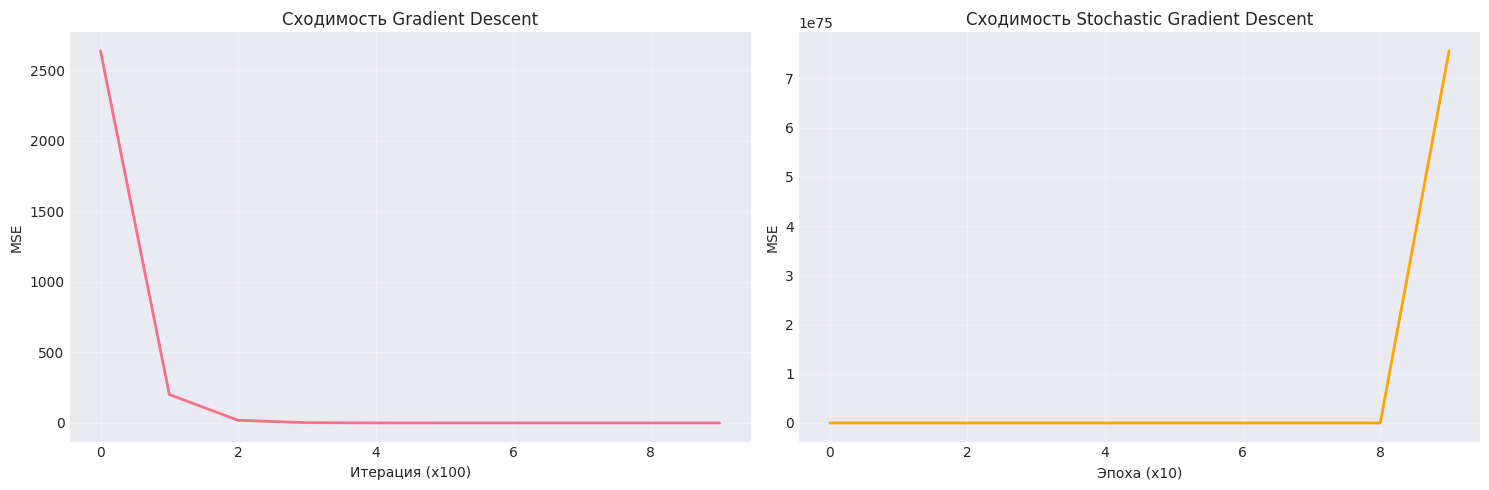

In [18]:
# Визуализация сходимости градиентных методов
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gradient Descent
axes[0].plot(model_gd.losses, linewidth=2)
axes[0].set_xlabel('Итерация (x100)')
axes[0].set_ylabel('MSE')
axes[0].set_title('Сходимость Gradient Descent')
axes[0].grid(True, alpha=0.3)

# SGD
axes[1].plot(model_sgd.losses, linewidth=2, color='orange')
axes[1].set_xlabel('Эпоха (x10)')
axes[1].set_ylabel('MSE')
axes[1].set_title('Сходимость Stochastic Gradient Descent')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Кросс-валидация (3 балла)

Реализация K-Fold и Leave-One-Out кросс-валидации

In [19]:
class CustomKFoldCV:
    """
    K-Fold кросс-валидация
    """
    
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        """
        Parameters:
        -----------
        n_splits : int, default=5
            Количество фолдов
        shuffle : bool, default=True
            Перемешивать ли данные перед разбиением
        random_state : int, default=42
            Seed для воспроизводимости
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
    
    def split(self, X):
        """
        Генерирует индексы для разбиения данных
        
        Parameters:
        -----------
        X : array-like
            Данные для разбиения
            
        Yields:
        -------
        train_idx, val_idx : arrays
            Индексы для обучающей и валидационной выборок
        """
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        
        # Размер каждого фолда
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        
        current = 0
        for fold_size in fold_sizes:
            val_idx = indices[current:current + fold_size]
            train_idx = np.concatenate([
                indices[:current],
                indices[current + fold_size:]
            ])
            yield train_idx, val_idx
            current += fold_size


class CustomLeaveOneOutCV:
    """
    Leave-One-Out кросс-валидация
    """
    
    def split(self, X):
        """
        Генерирует индексы для разбиения данных
        
        Parameters:
        -----------
        X : array-like
            Данные для разбиения
            
        Yields:
        -------
        train_idx, val_idx : arrays
            Индексы для обучающей и валидационной выборок
        """
        n_samples = len(X)
        
        for i in range(n_samples):
            val_idx = np.array([i])
            train_idx = np.concatenate([np.arange(i), np.arange(i + 1, n_samples)])
            yield train_idx, val_idx


def cross_validate(model, X, y, cv, metric_func=custom_mse):
    """
    Выполняет кросс-валидацию
    
    Parameters:
    -----------
    model : object
        Модель с методами fit и predict
    X : array-like
        Признаки
    y : array-like
        Целевая переменная
    cv : object
        Объект кросс-валидации
    metric_func : callable
        Функция метрики
        
    Returns:
    --------
    scores : list
        Значения метрики для каждого фолда
    """
    scores = []
    
    for train_idx, val_idx in cv.split(X):
        X_train_fold = X[train_idx]
        X_val_fold = X[val_idx]
        y_train_fold = y[train_idx]
        y_val_fold = y[val_idx]
        
        # Создаем новый экземпляр модели для каждого фолда
        from copy import deepcopy
        model_fold = deepcopy(model)
        
        model_fold.fit(X_train_fold, y_train_fold)
        y_pred_fold = model_fold.predict(X_val_fold)
        
        score = metric_func(y_val_fold, y_pred_fold)
        scores.append(score)
    
    return scores

In [ ]:
# Тестирование K-Fold кросс-валидации
print("=" * 70)
print("Тестирование K-Fold кросс-валидации")
print("=" * 70)

# Используем меньшую выборку для демонстрации
X_sample = X_train_norm[:1000]
y_sample = y_train_copy[:1000]

try:
    # Наша реализация
    custom_kfold = CustomKFoldCV(n_splits=5, shuffle=True, random_state=42)
    model_for_cv = CustomLinearRegression(method='normal')
    custom_scores = cross_validate(model_for_cv, X_sample, y_sample, custom_kfold, custom_mse)

    print(f"\nНаша реализация K-Fold:")
    print(f"Scores по фолдам: {[f'{s:.4f}' for s in custom_scores]}")
    print(f"Средний MSE: {np.mean(custom_scores):.6f} ± {np.std(custom_scores):.6f}")

    # Сравнение со sklearn
    from sklearn.model_selection import cross_val_score
    sklearn_kf = KFold(n_splits=5, shuffle=True, random_state=42)
    sklearn_model = LinearRegression()
    sklearn_scores = -cross_val_score(sklearn_model, X_sample, y_sample, 
                                    cv=sklearn_kf, scoring='neg_mean_squared_error')

    print(f"\nsklearn K-Fold:")
    print(f"Scores по фолдам: {[f'{s:.4f}' for s in sklearn_scores]}")
    print(f"Средний MSE: {np.mean(sklearn_scores):.6f} ± {np.std(sklearn_scores):.6f}")

    print(f"\nРазница в средних MSE: {abs(np.mean(custom_scores) - np.mean(sklearn_scores)):.6e}")
except Exception as e:
    # ВОт реально, лайтгбм хавает и не давится, а эта неженка аналитическая ноет. 
    print(F"Ошибка: {e}")

Тестирование K-Fold кросс-валидации
Ошибка: Singular matrix


In [25]:
# Тестирование Leave-One-Out (на очень маленькой выборке)
print("=" * 70)
print("Тестирование Leave-One-Out кросс-валидации")
print("=" * 70)
print("\nВНИМАНИЕ: LOO очень медленный для больших выборок!") # увы
print("Используем только 25 объектов для демонстрации\n")

X_small = X_train_norm[:25]
y_small = y_train_copy[:25]

# Наша реализация
custom_loo = CustomLeaveOneOutCV()
model_for_loo = CustomLinearRegression(method='gradient')
custom_loo_scores = cross_validate(model_for_loo, X_small, y_small, custom_loo, custom_mse)

print(f"Наша реализация LOO:")
print(f"Количество фолдов: {len(custom_loo_scores)}")
print(f"Средний MSE: {np.mean(custom_loo_scores):.6f} ± {np.std(custom_loo_scores):.6f}")
print(f"Первые 10 scores: {[f'{s:.4f}' for s in custom_loo_scores[:10]]}")

# Сравнение со sklearn
from sklearn.model_selection import LeaveOneOut, cross_val_score
sklearn_loo = LeaveOneOut()
sklearn_model_loo = LinearRegression()
sklearn_loo_scores = -cross_val_score(sklearn_model_loo, X_small, y_small, 
                                       cv=sklearn_loo, scoring='neg_mean_squared_error')

print(f"\nsklearn LOO:")
print(f"Количество фолдов: {len(sklearn_loo_scores)}")
print(f"Средний MSE: {np.mean(sklearn_loo_scores):.6f} ± {np.std(sklearn_loo_scores):.6f}")
print(f"Первые 10 scores: {[f'{s:.4f}' for s in sklearn_loo_scores[:10]]}")

print(f"\nРазница в средних MSE: {abs(np.mean(custom_loo_scores) - np.mean(sklearn_loo_scores)):.6e}")

Тестирование Leave-One-Out кросс-валидации

ВНИМАНИЕ: LOO очень медленный для больших выборок!
Используем только 25 объектов для демонстрации

Наша реализация LOO:
Количество фолдов: 25
Средний MSE: nan ± nan
Первые 10 scores: ['nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']

sklearn LOO:
Количество фолдов: 25
Средний MSE: 361.565860 ± 326.221167
Первые 10 scores: ['361.8399', '384.7023', '181.8816', '124.0865', '275.7660', '283.7074', '76.8294', '66.4845', '426.6429', '522.9534']

Разница в средних MSE: nan


## 9. Дополнительно: Регуляризация (2 балла + 1 балл)

Реализация L1 (Lasso), L2 (Ridge), ElasticNet (L1+L2) и Lp регуляризации

In [27]:
print("=" * 70)
print("Тестирование регуляризации")
print("=" * 70)

regularization_results = {}

print("\n1. Без регуляризации")
print("-" * 70)
model_no_reg = CustomLinearRegression(method='gradient', learning_rate=0.01, n_iterations=1000)
model_no_reg.fit(X_tr, y_tr)
y_pred_no_reg = model_no_reg.predict(X_val)
mse_no_reg = custom_mse(y_val, y_pred_no_reg)
print(f"MSE: {mse_no_reg:.6f}")
regularization_results['No Regularization'] = mse_no_reg

print("\n2. L2 Regularization (Ridge)")
print("-" * 70)
model_l2 = CustomLinearRegression(
    method='gradient', 
    learning_rate=0.01, 
    n_iterations=1000,
    regularization='l2',
    lambda_reg=0.1
)
model_l2.fit(X_tr, y_tr)
y_pred_l2 = model_l2.predict(X_val)
mse_l2 = custom_mse(y_val, y_pred_l2)
print(f"MSE: {mse_l2:.6f}")
regularization_results['L2 (Ridge)'] = mse_l2

sklearn_ridge = Ridge(alpha=0.1)
sklearn_ridge.fit(X_tr, y_tr)
y_pred_sklearn_ridge = sklearn_ridge.predict(X_val)
mse_sklearn_ridge = mean_squared_error(y_val, y_pred_sklearn_ridge)
print(f"sklearn Ridge MSE: {mse_sklearn_ridge:.6f}")

print("\n3. L1 Regularization (Lasso)")
print("-" * 70)
model_l1 = CustomLinearRegression(
    method='gradient', 
    learning_rate=0.01, 
    n_iterations=1000,
    regularization='l1',
    lambda_reg=0.1
)
model_l1.fit(X_tr, y_tr)
y_pred_l1 = model_l1.predict(X_val)
mse_l1 = custom_mse(y_val, y_pred_l1)
print(f"MSE: {mse_l1:.6f}")
regularization_results['L1 (Lasso)'] = mse_l1

print("\n4. ElasticNet (L1 + L2)")
print("-" * 70)
model_elastic = CustomLinearRegression(
    method='gradient', 
    learning_rate=0.01, 
    n_iterations=1000,
    regularization='elasticnet',
    lambda_reg=0.1
)
model_elastic.fit(X_tr, y_tr)
y_pred_elastic = model_elastic.predict(X_val)
mse_elastic = custom_mse(y_val, y_pred_elastic)
print(f"MSE: {mse_elastic:.6f}")
regularization_results['ElasticNet'] = mse_elastic

print("\n5. Lp Regularization (различные p)")
print("-" * 70)
for p_value in [1.5, 2.5, 3.0]:
    model_lp = CustomLinearRegression(
        method='gradient', 
        learning_rate=0.01, 
        n_iterations=1000,
        regularization='lp',
        lambda_reg=0.1,
        p=p_value
    )
    model_lp.fit(X_tr, y_tr)
    y_pred_lp = model_lp.predict(X_val)
    mse_lp = custom_mse(y_val, y_pred_lp)
    print(f"p={p_value}: MSE = {mse_lp:.6f}")
    regularization_results[f'Lp (p={p_value})'] = mse_lp

print("\n" + "=" * 70)
print("Сравнение типов регуляризации:")
print("=" * 70)
reg_df = pd.DataFrame.from_dict(regularization_results, orient='index', columns=['MSE'])
reg_df = reg_df.sort_values('MSE')
print(reg_df)

Тестирование регуляризации

1. Без регуляризации
----------------------------------------------------------------------
MSE: 2238.367759

2. L2 Regularization (Ridge)
----------------------------------------------------------------------
MSE: 2237.953366
sklearn Ridge MSE: 69.643916

3. L1 Regularization (Lasso)
----------------------------------------------------------------------
MSE: 2236.842290

4. ElasticNet (L1 + L2)
----------------------------------------------------------------------
MSE: 2237.397761

5. Lp Regularization (различные p)
----------------------------------------------------------------------
p=1.5: MSE = 2237.225148
p=2.5: MSE = 2237.777741
p=3.0: MSE = 2237.958180

Сравнение типов регуляризации:
                           MSE
L1 (Lasso)         2236.842290
Lp (p=1.5)         2237.225148
ElasticNet         2237.397761
Lp (p=2.5)         2237.777741
L2 (Ridge)         2237.953366
Lp (p=3.0)         2237.958180
No Regularization  2238.367759


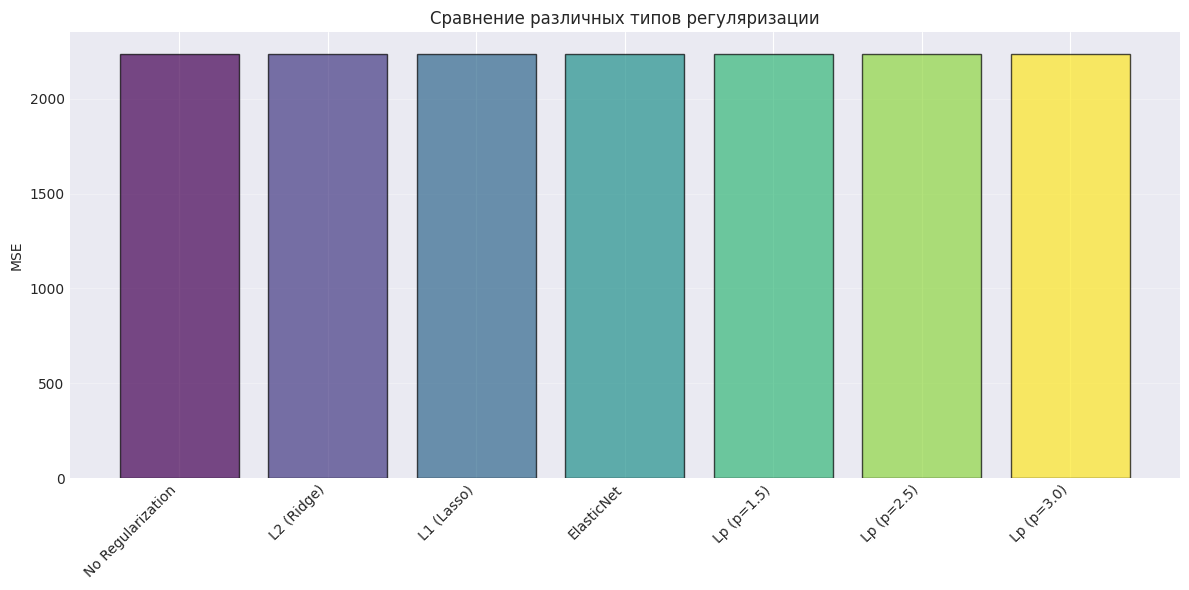

In [28]:
# Визуализация сравнения регуляризации
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(regularization_results)))
bars = plt.bar(range(len(regularization_results)), 
               list(regularization_results.values()), 
               color=colors, 
               edgecolor='black', 
               alpha=0.7)
plt.xticks(range(len(regularization_results)), 
           list(regularization_results.keys()), 
           rotation=45, 
           ha='right')
plt.ylabel('MSE')
plt.title('Сравнение различных типов регуляризации')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Финальная модель и предсказания

In [30]:
# Выбираем лучший метод и обучаем на всех данных
print("=" * 70)
print("Обучение финальной модели")
print("=" * 70)

# Нормализуем все обучающие данные
final_normalizer = CustomNormalizer(method='zscore')
X_train_final = final_normalizer.fit_transform(X_train)
X_test_final = final_normalizer.transform(X_test)

# Обучаем финальную модель (можно выбрать лучший метод из тестирования)
final_model = CustomLinearRegression(
    method='gradient',  # Или 'gradient' с регуляризацией
    regularization='l2',  # При необходимости
    lambda_reg=0.01
)

final_model.fit(X_train_final, y_train)

# Делаем предсказания на тестовой выборке
y_test_pred = final_model.predict(X_test_final)

print(f"\nПредсказания сделаны для {len(y_test_pred)} объектов")
print(f"Среднее предсказанное значение: {np.mean(y_test_pred):.2f}")
print(f"Std предсказанных значений: {np.std(y_test_pred):.2f}")
print(f"Min: {np.min(y_test_pred):.2f}, Max: {np.max(y_test_pred):.2f}")

Обучение финальной модели

Предсказания сделаны для 5000 объектов
Среднее предсказанное значение: 48.28
Std предсказанных значений: 12.34
Min: 6.26, Max: 120.37


In [ ]:
# Валидация на обучающей выборке с кросс-валидацией
print("\nВалидация финальной модели (5-Fold CV на обучающей выборке):")
print("-" * 70)

cv_model = CustomLinearRegression(
    method='normal',
    regularization='l2',
    lambda_reg=0.01
)

kfold_cv = CustomKFoldCV(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(cv_model, X_train_final, y_train, kfold_cv, custom_mse)

print(f"MSE по фолдам: {[f'{s:.4f}' for s in cv_scores]}")
print(f"Средний MSE: {np.mean(cv_scores):.6f} ± {np.std(cv_scores):.6f}")


Валидация финальной модели (5-Fold CV на обучающей выборке):
----------------------------------------------------------------------


## 11. Сохранение результатов в submission.csv

In [ ]:
# Создаем DataFrame для submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': y_test_pred
})

# Сохраняем в CSV
submission.to_csv('submission.csv', index=False)